__Library__

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

__Preprocessing__

In [2]:
# Define paths
BASE_DIR = './datasets'
CATEGORIES = ['Bleeding', 'Ischemia', 'Normal']

def generate_mask_from_overlay(original_path, overlay_path):
    """
    Creates a binary mask by isolating the differences between the 
    original PNG and the OVERLAY image.
    """
    # Load images
    img_orig = cv2.imread(original_path)
    img_overlay = cv2.imread(overlay_path)
    
    # Ensure they are the same size
    if img_orig.shape != img_overlay.shape:
        img_overlay = cv2.resize(img_overlay, (img_orig.shape[1], img_orig.shape[0]))

    # Calculate absolute difference
    diff = cv2.absdiff(img_orig, img_overlay)
    
    # Convert difference to grayscale
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
    # Threshold to create binary mask (pixel > 10 usually indicates annotation)
    _, mask = cv2.threshold(gray_diff, 10, 255, cv2.THRESH_BINARY)
    
    return mask

def visualize_sample(category, file_id):
    """Helper to visualize the extraction process"""
    png_path = f"{BASE_DIR}/{category}/PNG/{file_id}.png"
    overlay_path = f"{BASE_DIR}/{category}/OVERLAY/{file_id}.png"
    
    if not os.path.exists(png_path):
        print(f"File not found: {png_path}")
        return

    original = cv2.imread(png_path)
    overlay = cv2.imread(overlay_path)
    generated_mask = generate_mask_from_overlay(png_path, overlay_path)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(original)
    ax[0].set_title("Original CT (Input)")
    ax[1].imshow(overlay)
    ax[1].set_title("Provided Overlay")
    ax[2].imshow(generated_mask, cmap='gray')
    ax[2].set_title("Generated Binary Mask (Target)")
    plt.show()

__Custom Dataset Class__

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class BrainStrokeDataset(Dataset):
    def __init__(self, root_dir, categories=['Bleeding', 'Ischemia', 'Normal'], transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size
        self.samples = []

        # 1. Gather all file paths
        for category in categories:
            png_dir = os.path.join(root_dir, category, 'PNG')
            overlay_dir = os.path.join(root_dir, category, 'OVERLAY')
            
            # Normal category might not have an OVERLAY folder, or we ignore it
            files = os.listdir(png_dir)
            
            for file in files:
                if file.endswith('.png'):
                    # Store tuple: (path_to_png, path_to_overlay, category_name)
                    png_path = os.path.join(png_dir, file)
                    
                    if category == 'Normal':
                        overlay_path = None # No overlay for normal
                    else:
                        overlay_path = os.path.join(overlay_dir, file)
                    
                    self.samples.append((png_path, overlay_path, category))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        png_path, overlay_path, category = self.samples[idx]
        
        # 1. Load Input Image
        # Convert to grayscale (L) as CTs are monochrome
        image = Image.open(png_path).convert("L") 
        image = image.resize(self.img_size)

        # 2. Load or Generate Mask
        if category == 'Normal':
            # Create a black mask for Normal cases
            mask_np = np.zeros((self.img_size[1], self.img_size[0]), dtype=np.uint8)
            mask = Image.fromarray(mask_np)
        else:
            # Generate mask from overlay for Bleeding/Ischemia
            # We use the cv2 logic defined earlier, but adapted for PIL flow or re-implement
            # For speed in Dataset, let's do a direct load if possible, 
            # but since we need subtraction, we use numpy:
            
            img_cv = cv2.imread(png_path)
            ovl_cv = cv2.imread(overlay_path)
            
            if img_cv.shape != ovl_cv.shape:
                ovl_cv = cv2.resize(ovl_cv, (img_cv.shape[1], img_cv.shape[0]))
                
            diff = cv2.absdiff(img_cv, ovl_cv)
            gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
            _, mask_np = cv2.threshold(gray_diff, 10, 255, cv2.THRESH_BINARY)
            
            mask = Image.fromarray(mask_np).resize(self.img_size, resample=Image.NEAREST)

        # 3. Apply Transforms (Convert to Tensor)
        # Note: We manually convert to tensor to ensure mask remains 0/1
        
        image_np = np.array(image, dtype=np.float32) / 255.0 # Normalize 0-1
        mask_np = np.array(mask, dtype=np.float32) / 255.0   # Normalize 0-1
        
        # Add channel dimension: (H, W) -> (1, H, W)
        image_tensor = torch.tensor(image_np).unsqueeze(0)
        mask_tensor = torch.tensor(mask_np).unsqueeze(0)

        return image_tensor, mask_tensor

__Sanity Check__

Image Batch Shape: torch.Size([8, 1, 256, 256])
Mask Batch Shape: torch.Size([8, 1, 256, 256])


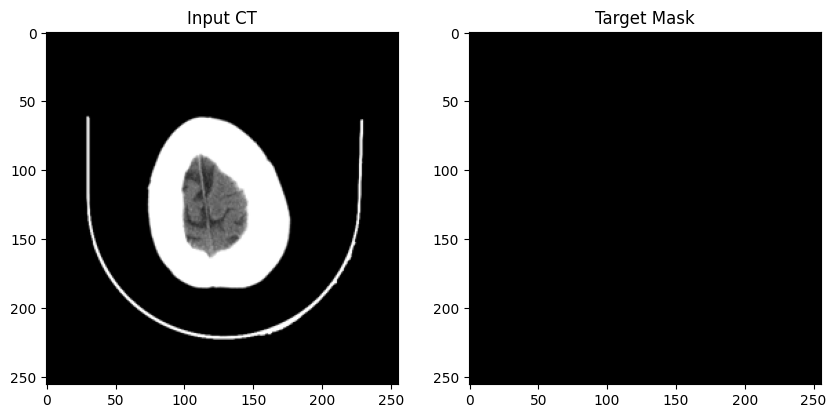

In [4]:
# Initialize Dataset
dataset = BrainStrokeDataset(BASE_DIR, img_size=(256, 256))

# Split into Train/Val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create Loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Fetch a batch to verify
images, masks = next(iter(train_loader))

print(f"Image Batch Shape: {images.shape}") # Should be [8, 1, 256, 256]
print(f"Mask Batch Shape: {masks.shape}")   # Should be [8, 1, 256, 256]

# Quick visualization of the first item in batch
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title("Input CT")
plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title("Target Mask")
plt.show()

__U-Net Architecture__

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Downscaling (Encoder)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Upscaling (Decoder)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(1024, 512) # 1024 because of skip connection
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder + Skip Connections
        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.up_conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.up_conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up_conv3(x)

        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv4(x)

        logits = self.outc(x)
        return torch.sigmoid(logits) # Output values between 0 and 1

__Loss Function (Dice Loss)__

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predict, target):
        predict = predict.view(-1)
        target = target.view(-1)
        
        intersection = (predict * target).sum()
        dice = (2. * intersection + self.smooth) / (predict.sum() + target.sum() + self.smooth)
        
        return 1 - dice

__Initialization & Training Configuration__

In [9]:
# 1. Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Instantiate Model
model = UNet(n_channels=1, n_classes=1).to(device)

# 3. Loss and Optimizer
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 4. Summary of the model
from torchsummary import summary
summary(model, (1, 256, 256))

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14

__The Training Loop__

In [ ]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs=25, lr=1e-4):
    criterion = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()

        avg_train = running_train_loss / len(train_loader)
        avg_val = running_val_loss / len(val_loader)
        
        train_losses.append(avg_train)
        val_losses.append(avg_val)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train:.4f} - Val Loss: {avg_val:.4f}")

    return train_losses, val_losses

# Execute training
history = train_model(model, train_loader, val_loader, epochs=20)

NameError: name 'val_loader' is not defined

__Prediction & Visualization__

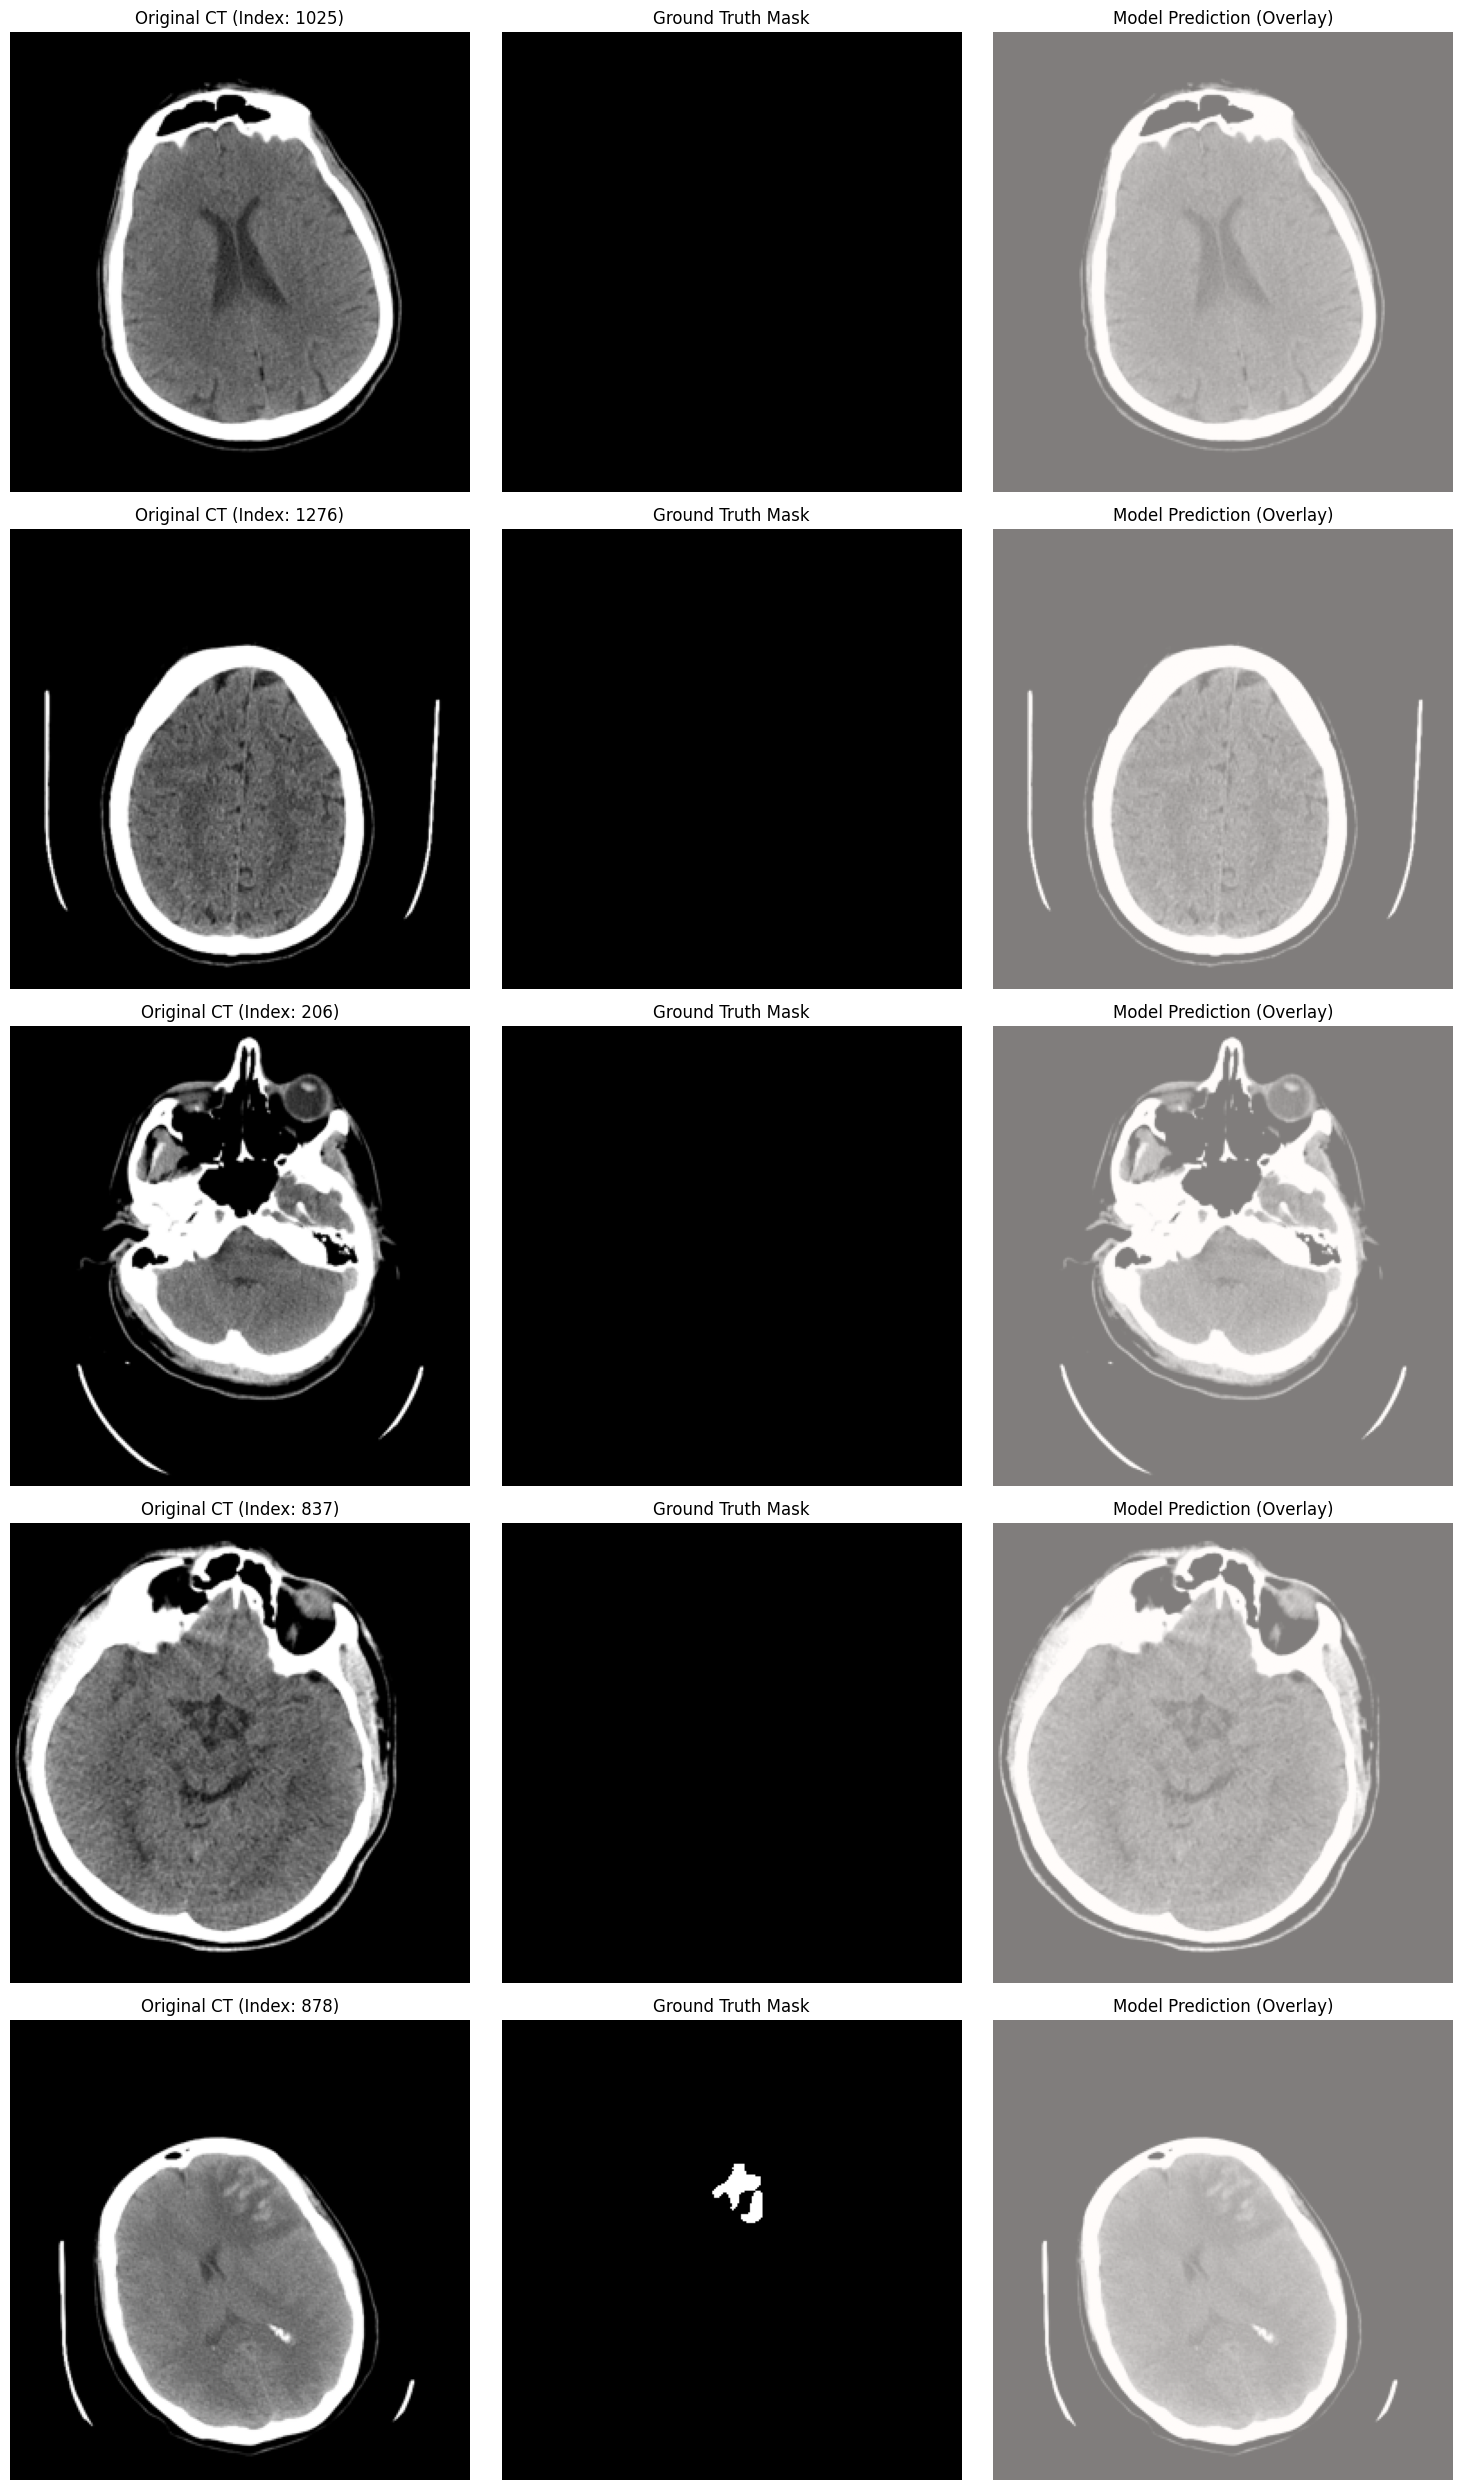

In [13]:
def visualize_predictions(model, dataset, num_samples=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    
    # Randomly pick indices from the dataset
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]
            
            # Prepare image for model (add batch dimension and move to device)
            input_tensor = image.unsqueeze(0).to(device)
            
            # Get prediction
            output = model(input_tensor)
            # Remove batch/channel dims and move back to CPU
            pred_mask = output.squeeze().cpu().numpy()
            
            # Thresholding the prediction (e.g., probability > 0.5 = stroke)
            binary_pred = (pred_mask > 0.5).astype(np.uint8)

            # Plotting
            axes[i, 0].imshow(image.squeeze(), cmap='gray')
            axes[i, 0].set_title(f"Original CT (Index: {idx})")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask.squeeze(), cmap='gray')
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis('off')

            axes[i, 2].imshow(binary_pred, cmap='Reds', alpha=0.5) # Overlay red on prediction
            axes[i, 2].imshow(image.squeeze(), cmap='gray', alpha=0.5)
            axes[i, 2].set_title("Model Prediction (Overlay)")
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Run this after training
visualize_predictions(model, val_dataset)